#1. 합성곱 신경망
- 역전파는 신경망의 모든 노드로 전송 -> 복잡하고 많은 자원을 요구
- 이를 해결 -> **합성곱 신경망**
- 이미지 전체를 한 번에 계산하는 것이 아닌 이미지의 국소적 부분을 계산 -> 시간과 자원 절약
- 이미지나 영상을 처리하는 데 유용
- 계층은 다섯 개, 입력층, 합성곱층, 풀링층, 완전연결층, 출력층
- 입력층 : 입력 이미지 데이터가 최초로 거치게 되는 계층. 이미지는 높이, 너비, 채널의 값을 갖는 3차원 데이터.
- 합성곱층 : 입력 데이터에서 특성을 추출하는 역할 -> 커널이나 필터 사용
- 풀링층 : 합성곱층과 유사하게 특성 맵의 차원을 다운 샘플링 -> 연산량을 감소시키고 주요한 특성 벡터를 추출, 학습을 효과적으로 할 수 있게 한다. 최대 풀링, 평균 풀링 두 가지.
- 완전연결층 : 합성곱층과 풀링층을 거치면서 차원이 축소된 특성 맵은 최종적으로 완전연결층으로 전달된다. 이미지가 3차원 벡터에서 1차원 벡터로 펼쳐지게 된다.
- 출력층 : 소프트맥스 활성화 함수가 사용되는데, 입력받은 값을 0~1 사이의 값으로 출력. 마지막 출력층의 소프트맥스 함수를 사용하여 이미지가 각 레이블에 속할 확률 값이 출력되고, 이때 가장 높은 확률값을 가진 레이블이 최종 값으로 선정
- 1D 합성곱 : 필터가 시간을 축으로, 좌우로만 이동할 수 있는 합성곱
- 2D 합성곱 : 필터가 방향 두 개로 움직이는 형태, 출력 형태는 2D 행렬
- 3D 합성곱 : 필터가 움직이는 방향이 세 개. d < L 유지 중요.

#2. 합성곱 신경망 맛보기
- fashion_mnist 데이터를 메모리로 불러오기 위해 데이터로더(DataLoader)에 연결
- batch_size : 데이터를 배치로 묶음. 100이면 100개 단위로 데이터를 묶어서 불러옴
- np.random : 무작위로 데이터를 생성할 때 사용
- 클래스 형태의 모델은 항상 torch.nn.Module을 상속받음. init은 속성 값 초기화의 역할, 객체가 생성될 때 자동으로 호출됨.
- 데이터 연산 진행은 forward() 부분에서 이루어짐.
- forward()는 모델이 학습 데이터를 입력받아서 순전파 학습을 진행시키고, 반드시 forward라는 이름의 함수여야 한다.
- 활성화 함수를 지정할 때는 두 가지가 가능.
    - F.relu() : forward()에서 정의
    - nn,ReLU() : init에서 정의
- Autograd는 자동 미분을 수행하는 파이토치의 핵심 패키지, 값을 저장하기 위해 테이프(tape) 사용
- 역전파 단계에서 저장된 값들을 꺼내서 사용

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:01<00:00, 16756404.53it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 313821.87it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5584083.70it/s]


Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18083984.08it/s]

Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

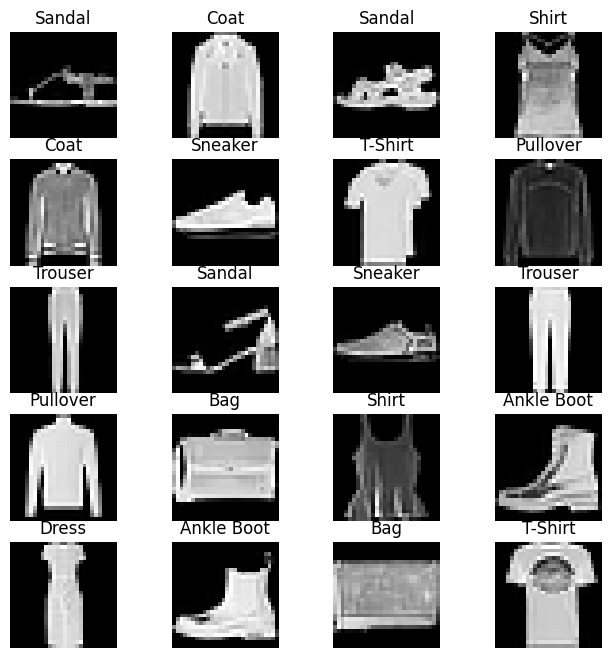

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=784,out_features=256)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    def forward(self,input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [ ]:
import torch
import torch.nn as nn

inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
outputs = conv(inputs)
layer = nn.Conv2d(1, 1, 3)

In [ ]:
import torch.nn.functional as F

inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1)

In [ ]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.647731602191925, Accuracy: 83.18000030517578%
Iteration: 1000, Loss: 0.5234462022781372, Accuracy: 84.06999969482422%
Iteration: 1500, Loss: 0.32822495698928833, Accuracy: 84.45999908447266%
Iteration: 2000, Loss: 0.35557785630226135, Accuracy: 85.31999969482422%
Iteration: 2500, Loss: 0.2654860019683838, Accuracy: 86.0199966430664%
Iteration: 3000, Loss: 0.27967602014541626, Accuracy: 86.44000244140625%


In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [ ]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.4610583782196045, Accuracy: 87.8499984741211%
Iteration: 1000, Loss: 0.34070971608161926, Accuracy: 89.04000091552734%
Iteration: 1500, Loss: 0.3117886781692505, Accuracy: 87.97000122070312%
Iteration: 2000, Loss: 0.1946103423833847, Accuracy: 89.8499984741211%
Iteration: 2500, Loss: 0.1578335464000702, Accuracy: 89.69000244140625%
Iteration: 3000, Loss: 0.1433115452528, Accuracy: 90.5%
